<a href="https://colab.research.google.com/github/CaritoRamos/Predictive-Classification-Model-for-UNMSM-Admissions/blob/main/notebooks/Predictive_Classification_Model_for_UNMSM_Admissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook presents the development of a predictive classification model aimed at estimating whether an applicant will be admitted or not to the National University of San Marcos (UNMSM). The model is trained and evaluated using historical admission data from 2023 to 2025, specifically for the EBR (Regular Basic Education) and EBA (Alternative Basic Education) admission categories.

# **1. DATA WRANGLING**

In [ ]:
#Libraries
!pip install plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import files
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind


#For Model:
!pip install scikit-learn xgboost lightgbm catboost
!pip install gender-guesser
import gender_guesser.detector as gender
import joblib #To save the trained modelo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.inspection import permutation_importance

**JOINING DATASETS**

This folder contains the cleaned datasets previously obtained through web scraping of UNMSM admission exam results from 2023 to 2025, covering both admission periods (I and II) for each year. These separate files will now be merged into a single consolidated dataset for further analysis.


In [ ]:
#all datasets to be merged:
df1 = pd.read_csv('https://raw.githubusercontent.com/CaritoRamos/DataSets/refs/heads/main/Processed%20UNMSM%20Admission%20Data/2023_1.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/CaritoRamos/DataSets/refs/heads/main/Processed%20UNMSM%20Admission%20Data/2023_2.csv')
df3 = pd.read_csv('https://raw.githubusercontent.com/CaritoRamos/DataSets/refs/heads/main/Processed%20UNMSM%20Admission%20Data/2024_1.csv')
df4 = pd.read_csv('https://raw.githubusercontent.com/CaritoRamos/DataSets/refs/heads/main/Processed%20UNMSM%20Admission%20Data/2024_2.csv')
df5 = pd.read_csv('https://raw.githubusercontent.com/CaritoRamos/DataSets/refs/heads/main/Processed%20UNMSM%20Admission%20Data/2025_1.csv')
df6 = pd.read_csv('https://raw.githubusercontent.com/CaritoRamos/DataSets/refs/heads/main/Processed%20UNMSM%20Admission%20Data/2025_2.csv')

In [ ]:
#into a single one
df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

In [ ]:
df.to_csv("historical_data.csv", index=False, encoding="utf-8")
files.download('historical_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/CaritoRamos/Predictive-Classification-Model-for-UNMSM-Admissions/refs/heads/main/historical_data.csv')
df.head()

<ipython-input-75-6675085299d6>:1: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



,CODIGO,APELLIDOS Y NOMBRES,CARRERA,PUNTAJE,PUESTO,ESTATUS,MODALIDAD,SEDE,AÑO,PERIODO
0,108704,"ABAD GRANDA, ANDRE FAHET",MEDICINA HUMANA,1007.1250,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
1,159787,"ABAD NEYRA, ANDREA TAIS",MEDICINA HUMANA,480.3750,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
2,100330,"ABAL YACSAYAURI, SOFIA BELEN",MEDICINA HUMANA,504.8750,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
3,121362,"ABANTO ARAUJO, PERCY ANGEL",MEDICINA HUMANA,733.6250,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
4,139925,"ABANTO AYALA, LARISSA TAMARA",MEDICINA HUMANA,733.6250,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I


In [ ]:
#dataset size
df.shape

(145212, 10)

In [ ]:
df.dtypes

,0
CODIGO,int64
APELLIDOS Y NOMBRES,object
CARRERA,object
PUNTAJE,object
PUESTO,object
ESTATUS,object
MODALIDAD,object
SEDE,object
AÑO,int64
PERIODO,object


In [ ]:
df['PUNTAJE'] = pd.to_numeric(df['PUNTAJE'], errors='coerce')

# 1.1. Duplicated values

In [ ]:
#unique values
df.nunique()

,0
CODIGO,145194
APELLIDOS Y NOMBRES,89252
CARRERA,84
PUNTAJE,8969
PUESTO,460
ESTATUS,4
MODALIDAD,12
SEDE,8
AÑO,3
PERIODO,2


In [ ]:
#duplicated values
df["CODIGO"].duplicated().sum()

np.int64(18)

In [ ]:
#to check the duplicated rows
#df.loc[df["CODIGO"].duplicated(keep=False), "CODIGO"]
df.loc[df["CODIGO"].duplicated(), "CODIGO"].unique()

array([104325, 145572, 133507, 109730, 114921, 182147, 152897, 168431,
       111641, 119954, 114150, 160487, 132731, 192268, 183934, 101571,
       153501, 100179])

In [ ]:
#removing duplicated rows, keeping only the first occurrence
df = df[~(df["CODIGO"].duplicated(keep='first'))]

In [ ]:
df["CODIGO"].duplicated().sum()

np.int64(0)

# 1.2. Null values

In [ ]:
#null values per column
print(df.isna().sum())

CODIGO                     0
APELLIDOS Y NOMBRES        0
CARRERA                    0
PUNTAJE                 3161
PUESTO                 67167
ESTATUS                    0
MODALIDAD                  0
SEDE                       0
AÑO                        0
PERIODO                    0
dtype: int64


In [ ]:
#applicants with null score
df[df["PUNTAJE"].isna()]["ESTATUS"].value_counts()

,count
ESTATUS,
AUSENTE,2615
INGRESO,545
ANULADO,1


These rows correspond to applicants who were absent during the admission exam.
Additionally, all rows with the status "Anulado" will also be removed from the dataset.

In [ ]:
df = df[~df['ESTATUS'].isin(['AUSENTE', 'ANULADO'])]
df

,CODIGO,APELLIDOS Y NOMBRES,CARRERA,PUNTAJE,PUESTO,ESTATUS,MODALIDAD,SEDE,AÑO,PERIODO
0,108704,"ABAD GRANDA, ANDRE FAHET",MEDICINA HUMANA,1007.125,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
1,159787,"ABAD NEYRA, ANDREA TAIS",MEDICINA HUMANA,480.375,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
2,100330,"ABAL YACSAYAURI, SOFIA BELEN",MEDICINA HUMANA,504.875,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
3,121362,"ABANTO ARAUJO, PERCY ANGEL",MEDICINA HUMANA,733.625,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
4,139925,"ABANTO AYALA, LARISSA TAMARA",MEDICINA HUMANA,733.625,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
...,...,...,...,...,...,...,...,...,...,...
145207,146772,"SILVESTRE ATOCHE, MATTEO MARTIN",TEC. MED. TERAPIA FÍSICA Y REHABILITACIÓN,608.250,1.0,INGRESO,DEPORTISTAS CALIFICADOS DE ALTO NIVEL,LIMA,2025,II
145208,182148,"TUPIÑO COLQUI, ANGIELI MARIA SOFIA",TEC. MED. TERAPIA FÍSICA Y REHABILITACIÓN,560.875,NaN,NO INGRESO,DEPORTISTAS CALIFICADOS DE ALTO NIVEL,LIMA,2025,II
145209,743153,"CÁCERES SANDOVAL, EDUARDO",COMUNICACIÓN SOCIAL,981.625,1.0,INGRESO,DEPORTISTAS CALIFICADOS DE ALTO NIVEL,LIMA,2025,II
145210,815534,"BAYLON CAMPOJO, LUIS FABRIZZIO",EDUCACIÓN FÍSICA,979.501,1.0,INGRESO,DEPORTISTAS CALIFICADOS DE ALTO NIVEL,LIMA,2025,II


There are different types of values in the PUNTAJE column.

In [ ]:
df['PUNTAJE'].unique()

array([1007.125,  480.375,  504.875, ..., 1029.039,  391.25 ,  979.501])

In [ ]:
#values that are not floats:
df.loc[pd.to_numeric(df['PUNTAJE'], errors='coerce').isna(), 'PUNTAJE'].unique()

array([nan])

In [ ]:
#removing rows with NaN values:
df = df[pd.to_numeric(df['PUNTAJE'], errors='coerce').notna()]
df.shape

(142033, 10)

In [ ]:
# Filtering EBR & EBA modality and Lima sede
#df = df[(df['MODALIDAD'].isin(['EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁSICA ALTERNATIVA (EBA)'])) & (df['SEDE'] == 'LIMA')].copy()

df = df[(df['MODALIDAD'].isin(['EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁSICA ALTERNATIVA (EBA)']))].copy()
df.head()

,CODIGO,APELLIDOS Y NOMBRES,CARRERA,PUNTAJE,PUESTO,ESTATUS,MODALIDAD,SEDE,AÑO,PERIODO
0,108704,"ABAD GRANDA, ANDRE FAHET",MEDICINA HUMANA,1007.125,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
1,159787,"ABAD NEYRA, ANDREA TAIS",MEDICINA HUMANA,480.375,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
2,100330,"ABAL YACSAYAURI, SOFIA BELEN",MEDICINA HUMANA,504.875,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
3,121362,"ABANTO ARAUJO, PERCY ANGEL",MEDICINA HUMANA,733.625,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I
4,139925,"ABANTO AYALA, LARISSA TAMARA",MEDICINA HUMANA,733.625,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I


In [ ]:
df.shape

(138496, 10)

# 1.3. New columns

1.3.1. AÑO_PERIODO

In [ ]:
#creating AÑO_PERIODO (combining year and period):
df['AÑO_PERIODO'] = df['AÑO'].astype(str) + '-' + df['PERIODO'].astype(str)

In [ ]:
df["AÑO_PERIODO"].unique()

array(['2023-I', '2023-II', '2024-I', '2024-II', '2025-I', '2025-II'],
      dtype=object)

In [ ]:
#dataset sorted chronologically
orden_periodos = ['2023-I', '2023-II', '2024-I', '2024-II', '2025-I', '2025-II']
df['AÑO_PERIODO'] = pd.Categorical(df['AÑO_PERIODO'], categories=orden_periodos, ordered=True)
df = df.sort_values(by=['APELLIDOS Y NOMBRES', 'AÑO_PERIODO'])

1.3.2. Nº POSTULACION

In [ ]:
#creating "Nº POSTULACION"
df['Nº POSTULACION'] = df.groupby('APELLIDOS Y NOMBRES').cumcount() + 1
df.head(100)

,CODIGO,APELLIDOS Y NOMBRES,CARRERA,PUNTAJE,PUESTO,ESTATUS,MODALIDAD,SEDE,AÑO,PERIODO,AÑO_PERIODO,Nº POSTULACION
13550,194152,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,644.875,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,II,2023-II,1
40901,119172,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,639.250,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2024,I,2024-I,2
68096,193714,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,686.000,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2024,II,2024-II,3
92839,123341,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,947.000,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025,I,2025-I,4
132861,594777,"ABAD ANCHIRAICO, FHARID ALI",ADMINISTRACIÓN DE NEGOCIOS INTERNACIONALES,1216.000,4.0,INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,S.J.L,2025,II,2025-II,5
...,...,...,...,...,...,...,...,...,...,...,...,...
105669,555579,"ABANTO CARBAJAL, AMANDA FABIANA",ECONOMÍA INTERNACIONAL,744.875,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025,I,2025-I,2
52539,591882,"ABANTO CCAHUANA, GUSTAVO ALONSO",ECONOMÍA,897.500,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2024,I,2024-I,1
77478,573305,"ABANTO CCAHUANA, GUSTAVO ALONSO",ECONOMÍA,1297.500,19.0,INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2024,II,2024-II,2
87326,848256,"ABANTO CCAHUANA, NICOLE ALEXANDRA",MEDICINA HUMANA,950.375,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025,I,2025-I,1


1.3.3. SEXO

This column is based on names from column 'APELLIDOS Y NOMBRES'. First, I separated the surnames from the given names using the comma as a delimiter. Then, I extracted the first name from the 'NOMBRES' column and used the gender-guesser library to predict the gender. If the first name didn’t give a clear result, I tried with the second name. Finally, I simplified the result to just 'M' for male or 'F' for female.

In [ ]:
#checking how many rows do not contain exactly one comma
df[~df['APELLIDOS Y NOMBRES'].str.contains(',', na=False)].shape[0]

0

In [ ]:
#counting how many rows do not split into exactly two parts
df['APELLIDOS Y NOMBRES'].str.split(',').apply(len).value_counts()

,count
APELLIDOS Y NOMBRES,
2,138493
3,3


In [ ]:
#inspecting rows with more than one comma
df[df['APELLIDOS Y NOMBRES'].str.count(',') > 1]

,CODIGO,APELLIDOS Y NOMBRES,CARRERA,PUNTAJE,PUESTO,ESTATUS,MODALIDAD,SEDE,AÑO,PERIODO,AÑO_PERIODO,Nº POSTULACION
134765,586923,"GUILLEN BENDEZU,, AARON URIEL",AUDITORÍA EMPRESARIAL Y DEL SECTOR PÚBLICO,848.375,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025,II,2025-II,1
23842,561668,"HUAMANI SEGOVIA, MARICIELO,KARLA",GESTIÓN TRIBUTARIA,862.625,15.0,INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,II,2023-II,1
24208,555459,"SUAREZ CONDORI, YESENIA , NELLY",PRESUPUESTO Y FINANZAS PÚBLICAS,671.625,54.0,INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,II,2023-II,1


In [ ]:
#manually correcting the affected rows
df.loc[134765, 'APELLIDOS Y NOMBRES'] = 'GUILLEN BENDEZU, AARON URIEL'
df.loc[23842, 'APELLIDOS Y NOMBRES'] = 'HUAMANI SEGOVIA, MARICIELO KARLA'
df.loc[24208, 'APELLIDOS Y NOMBRES'] = 'SUAREZ CONDORI, YESENIA NELLY'

In [ ]:
#splitting only at the first comma
df[['APELLIDOS', 'NOMBRES']] = df['APELLIDOS Y NOMBRES'].str.split(',', n=1, expand=True)

#removing extra white spaces.
df['APELLIDOS'] = df['APELLIDOS'].str.strip()
df['NOMBRES'] = df['NOMBRES'].str.strip()

In [ ]:
df.head()

,CODIGO,APELLIDOS Y NOMBRES,CARRERA,PUNTAJE,PUESTO,ESTATUS,MODALIDAD,SEDE,AÑO,PERIODO,AÑO_PERIODO,Nº POSTULACION,APELLIDOS,NOMBRES
13550,194152,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,644.875,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,II,2023-II,1,ABAD ANCHIRAICO,FHARID ALI
40901,119172,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,639.250,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2024,I,2024-I,2,ABAD ANCHIRAICO,FHARID ALI
68096,193714,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,686.000,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2024,II,2024-II,3,ABAD ANCHIRAICO,FHARID ALI
92839,123341,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,947.000,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025,I,2025-I,4,ABAD ANCHIRAICO,FHARID ALI
132861,594777,"ABAD ANCHIRAICO, FHARID ALI",ADMINISTRACIÓN DE NEGOCIOS INTERNACIONALES,1216.000,4.0,INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,S.J.L,2025,II,2025-II,5,ABAD ANCHIRAICO,FHARID ALI


In [ ]:
#initializing the gender detector.
d = gender.Detector()

#function to predict gender using first names
def obtener_sexo(nombre_str):
    try:
        nombres = nombre_str.strip().split()

        for nombre in nombres:
            nombre = nombre.capitalize()
            genero = d.get_gender(nombre)

            if genero in ['male', 'mostly_male']:
                return 'M'
            elif genero in ['female', 'mostly_female']:
                return 'F'

        #if no conclusive gender is found, return a default value
        return 'M'

    except:
        return 'M'

#applying the function
df['SEXO'] = df['NOMBRES'].apply(obtener_sexo)

In [ ]:
df.head(5478)

,CODIGO,APELLIDOS Y NOMBRES,CARRERA,PUNTAJE,PUESTO,ESTATUS,MODALIDAD,SEDE,AÑO,PERIODO,AÑO_PERIODO,Nº POSTULACION,APELLIDOS,NOMBRES,SEXO
13550,194152,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,644.875,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,II,2023-II,1,ABAD ANCHIRAICO,FHARID ALI,M
40901,119172,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,639.250,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2024,I,2024-I,2,ABAD ANCHIRAICO,FHARID ALI,M
68096,193714,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,686.000,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2024,II,2024-II,3,ABAD ANCHIRAICO,FHARID ALI,M
92839,123341,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,947.000,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025,I,2025-I,4,ABAD ANCHIRAICO,FHARID ALI,M
132861,594777,"ABAD ANCHIRAICO, FHARID ALI",ADMINISTRACIÓN DE NEGOCIOS INTERNACIONALES,1216.000,4.0,INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,S.J.L,2025,II,2025-II,5,ABAD ANCHIRAICO,FHARID ALI,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116160,897206,"ANAYA TUCNO, DAYANA SAYURI",MEDICINA HUMANA,520.625,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025,II,2025-II,1,ANAYA TUCNO,DAYANA SAYURI,F
35323,881372,"ANAYA VARGAS, JONATAN FRANCIS",MEDICINA HUMANA,497.250,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2024,I,2024-I,1,ANAYA VARGAS,JONATAN FRANCIS,M
87521,869514,"ANAYA VARGAS, JONATAN FRANCIS",MEDICINA HUMANA,771.250,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025,I,2025-I,2,ANAYA VARGAS,JONATAN FRANCIS,M
116161,880236,"ANAYA VARGAS, JONATAN FRANCIS",MEDICINA HUMANA,923.750,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025,II,2025-II,3,ANAYA VARGAS,JONATAN FRANCIS,M


⚠️ **Note:**

To develop a robust and reliable predictive model, and due to the lack of certain important variables in the admission results published by the university, I chose to generate synthetic data for features such as age and type of school attended (public or private). These values were randomly assigned and do not represent real data. Their purpose is to enrich the dataset and support the model training process.

In [ ]:
#generating a list of unique individuals
personas_unicas = df['APELLIDOS Y NOMBRES'].unique()

#a random age between 16 and 24 was assigned to each individual
edad_map = {persona: np.random.randint(16, 25) for persona in personas_unicas}

#a random school type ('Privado' or 'Nacional') was assigned to each individual
tipo_colegio_map = {persona: np.random.choice(['Privado', 'Nacional']) for persona in personas_unicas}

#adding the generated values to the original dataFrame
df['EDAD'] = df['APELLIDOS Y NOMBRES'].map(edad_map)
df['TIPO_COLEGIO'] = df['APELLIDOS Y NOMBRES'].map(tipo_colegio_map)

In [ ]:
df.head(4263)

,CODIGO,APELLIDOS Y NOMBRES,CARRERA,PUNTAJE,PUESTO,ESTATUS,MODALIDAD,SEDE,AÑO,PERIODO,AÑO_PERIODO,Nº POSTULACION,APELLIDOS,NOMBRES,SEXO,EDAD,TIPO_COLEGIO
13550,194152,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,644.875,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,II,2023-II,1,ABAD ANCHIRAICO,FHARID ALI,M,21,Privado
40901,119172,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,639.250,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2024,I,2024-I,2,ABAD ANCHIRAICO,FHARID ALI,M,21,Privado
68096,193714,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,686.000,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2024,II,2024-II,3,ABAD ANCHIRAICO,FHARID ALI,M,21,Privado
92839,123341,"ABAD ANCHIRAICO, FHARID ALI",ENFERMERÍA,947.000,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025,I,2025-I,4,ABAD ANCHIRAICO,FHARID ALI,M,21,Privado
132861,594777,"ABAD ANCHIRAICO, FHARID ALI",ADMINISTRACIÓN DE NEGOCIOS INTERNACIONALES,1216.000,4.0,INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,S.J.L,2025,II,2025-II,5,ABAD ANCHIRAICO,FHARID ALI,M,21,Privado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7548,116028,"ALVARADO HORNA, JHESSICA YOSMELYM",PSICOLOGÍA,378.375,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2023,I,2023-I,1,ALVARADO HORNA,JHESSICA YOSMELYM,M,17,Nacional
64072,886781,"ALVARADO HOUMA, STEVEN HIDEAKI",MEDICINA HUMANA,481.250,NaN,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2024,II,2024-II,1,ALVARADO HOUMA,STEVEN HIDEAKI,M,19,Nacional
87475,876270,"ALVARADO HOUMA, STEVEN HIDEAKI",MEDICINA HUMANA,345.250,,NO INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025,I,2025-I,2,ALVARADO HOUMA,STEVEN HIDEAKI,M,19,Nacional
130591,218054,"ALVARADO HUALLPA, CARLOS ANDRE",QUÍMICA,872.375,41.0,INGRESO,EDUCACIÓN BÁSICA REGULAR (EBR) Y EDUCACIÓN BÁS...,LIMA,2025,II,2025-II,1,ALVARADO HUALLPA,CARLOS ANDRE,M,22,Nacional


# 1.4. Removing columns

In [ ]:
#'PUESTO' was removed due to missing values that can't be handled properly.
df.drop(['PUESTO'],axis = 1, inplace = True)

In [ ]:
#'CODIGO' and 'APELLIDOS Y NOMBRES' were removed as they are irrelevant to the analysis.
df.drop(['CODIGO', 'APELLIDOS Y NOMBRES', 'APELLIDOS', 'NOMBRES', 'AÑO', 'MODALIDAD'],axis = 1, inplace = True)
df.head()

,CARRERA,PUNTAJE,ESTATUS,SEDE,PERIODO,AÑO_PERIODO,Nº POSTULACION,SEXO,EDAD,TIPO_COLEGIO
13550,ENFERMERÍA,644.875,NO INGRESO,LIMA,II,2023-II,1,M,21,Privado
40901,ENFERMERÍA,639.250,NO INGRESO,LIMA,I,2024-I,2,M,21,Privado
68096,ENFERMERÍA,686.000,NO INGRESO,LIMA,II,2024-II,3,M,21,Privado
92839,ENFERMERÍA,947.000,NO INGRESO,LIMA,I,2025-I,4,M,21,Privado
132861,ADMINISTRACIÓN DE NEGOCIOS INTERNACIONALES,1216.000,INGRESO,S.J.L,II,2025-II,5,M,21,Privado


# **2. EDA**

# 2.1. Exploring admission trends by year and period

In [ ]:
tabla1 = pd.crosstab(index=[df['AÑO_PERIODO']], columns=df['ESTATUS'])
tabla1

ESTATUS,INGRESO,NO INGRESO
AÑO_PERIODO,,
2023-I,402,7851
2023-II,3751,20334
2024-I,2124,26403
2024-II,2630,19238
2025-I,2553,25833
2025-II,3835,23542


In [ ]:
df_ingresantes = df[df['ESTATUS'] == 'INGRESO'].copy()  #extracting admitted students only

In [ ]:
#visualization: Stacked bar chart
df_grouped = df_ingresantes['AÑO_PERIODO'].value_counts().reset_index()
df_grouped.columns = ['AÑO_PERIODO', 'CANTIDAD']

fig = px.bar(df_grouped,
             x='AÑO_PERIODO',
             y='CANTIDAD',
             text='CANTIDAD',
             title='Admitted students by year and period',
             color='AÑO_PERIODO')

fig.show()

⚠️**Note:**

The data corresponding to the 2023-I admission period will be removed from the dataset due to its significantly lower number of records compared to other periods. It could introduce sampling bias or unwanted variance during model training, potentially compromising performance and generalization.

In [ ]:
df = df[df['AÑO_PERIODO'] != '2023-I'].copy()
df.head()

,CARRERA,PUNTAJE,ESTATUS,SEDE,PERIODO,AÑO_PERIODO,Nº POSTULACION,SEXO,EDAD,TIPO_COLEGIO
13550,ENFERMERÍA,644.875,NO INGRESO,LIMA,II,2023-II,1,M,21,Privado
40901,ENFERMERÍA,639.250,NO INGRESO,LIMA,I,2024-I,2,M,21,Privado
68096,ENFERMERÍA,686.000,NO INGRESO,LIMA,II,2024-II,3,M,21,Privado
92839,ENFERMERÍA,947.000,NO INGRESO,LIMA,I,2025-I,4,M,21,Privado
132861,ADMINISTRACIÓN DE NEGOCIOS INTERNACIONALES,1216.000,INGRESO,S.J.L,II,2025-II,5,M,21,Privado


In [ ]:
df_ingresantes = df[df['ESTATUS'] == 'INGRESO'].copy()  #actualization

In [ ]:
columns_x= ['EDAD', 'SEXO', 'TIPO_COLEGIO', ]

for col in columns_x:
    df_grouped = df_ingresantes.groupby(col).size().reset_index(name='CANTIDAD')

    fig = px.bar(
        df_grouped,
        x=col,
        y='CANTIDAD',
        title=f'Number of Admitted Students by {col}',
        labels={
            col: col.replace('_', ' ').title(),
            'CANTIDAD': 'Number of Admitted Students'
        },
        text='CANTIDAD'
    )

    fig.update_traces(textposition='outside')
    fig.update_layout(
        xaxis_title=col.replace('_', ' ').title(),
        yaxis_title='Number of Students',
        height=500,
        width=800
    )

    fig.show()

# 2.2. Majors with the highest and lowest admission probability

In [ ]:
#total applicants per program
postulantes_por_carrera = df['CARRERA'].value_counts()

#total admitted students per program
ingresantes_por_carrera = df_ingresantes['CARRERA'].value_counts()

#admission rate per program
tasa_ingreso = (ingresantes_por_carrera / postulantes_por_carrera).sort_values(ascending=False)

#top 10 majors with the highest admission probability
top10_mayor = tasa_ingreso.head(10)

#top 10 majors with the lowest admission probability
top10_menor = tasa_ingreso.tail(10)

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=top10_mayor.values,
    y=top10_mayor.index,
    orientation='h',
    marker=dict(color='green'),
    text=[f'{v:.2%}' for v in top10_mayor.values],
    textposition='outside',
    name='Top 10 Mayor Probabilidad de Ingreso'
))

fig.update_layout(
    title='Top 10 Majors with Highest Admission Rates',
    xaxis_title='Admission Rate',
    yaxis_title='Major',
    xaxis=dict(range=[0, 1]),
    yaxis=dict(autorange='reversed'),
    height=600,
    margin=dict(l=150, r=50, t=50, b=50)
)

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=top10_menor.values,
    y=top10_menor.index,
    orientation='h',
    marker=dict(color='orange'),
    text=[f'{v:.2%}' for v in top10_menor.values],
    textposition='outside',
    name='Top 10 Menor probabilidad de ingreso'
))

fig.update_layout(
    title='Top 10 Majors with Lowest Admission Rates',
    xaxis_title='Admission Rate',
    yaxis_title='Major',
    xaxis=dict(range=[0, 1]),
    yaxis=dict(autorange='reversed'),  # el más alto arriba
    height=600,
    margin=dict(l=150, r=50, t=50, b=50)
)

fig.show()

# 2.3. Majors with Highest Scores

In [ ]:
#getting high score for each program
puntaje_maximo = df.groupby('CARRERA')['PUNTAJE'].max().reset_index()
puntaje_maximo = puntaje_maximo.sort_values(by='PUNTAJE', ascending=False)

#top 10 programs by highest scores
top10_puntaje=puntaje_maximo.head(10)

In [ ]:
fig = px.line(
    puntaje_maximo.head(10),
    x='CARRERA',
    y='PUNTAJE',
    title='Top 10 Majors with Highest Score',
    labels={'PUNTAJE': 'High Score', 'CARRERA': 'Major'},
    markers=True
)

fig.update_layout(
    xaxis_tickangle=-15,
    height=500
)

fig.show()

In [ ]:
#number of applicants per program
conteo_postulantes = df_ingresantes['CARRERA'].value_counts().reset_index()
conteo_postulantes.columns = ['CARRERA', 'CANTIDAD']

#only top 10 of programs
conteo_top10 = conteo_postulantes[conteo_postulantes['CARRERA'].isin(top10_puntaje['CARRERA'])]

top10_combinado = puntaje_maximo.merge(conteo_top10, on='CARRERA') #joining

fig = go.Figure()

#max score line
fig.add_trace(go.Scatter(
    x=top10_combinado['CARRERA'],
    y=top10_combinado['PUNTAJE'],
    name='High Score',
    mode='lines+markers',
    yaxis='y1'
))

#histogram of applicants
fig.add_trace(go.Bar(
    x=top10_combinado['CARRERA'],
    y=top10_combinado['CANTIDAD'],
    name='Admitted students',
    yaxis='y2',
    opacity=0.6,
    marker_color='green'
))


fig.update_layout(
    title='Top 10 majors by highest scores and number of admitted students',
    xaxis=dict(title='Major'),
    yaxis=dict(title='High Score', side='left'),
    yaxis2=dict(
        title='Admitted students',
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0.5, y=1.1, orientation='h', xanchor='center'),
    height=500,
    xaxis_tickangle=-30
)

fig.show()

# 2.4. Admitted Students with Scores Under 900 Points



The minimum passing score of 900 points was set as a requirement to obtain a placement. However, this rule was not applied in some admission cycles (2023 and 2025, in the EBR and EBA modalities), allowing applicants with lower scores to be admitted.

The objective of this analysis is to show how many admitted students would not have gotten a placement if the minimum score rule had still been in place. It is clear that in several academic programs, a significant number of students were admitted with scores below the minimum, which could affect academic quality, fairness in the admission process, and may require a review of admission policies.

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go


#EBR/EBA admits <900 pts in 2023 & 2025
df_filtrado = df_ingresantes[
    (df_ingresantes['AÑO_PERIODO'].isin(['2023-I', '2023-II', '2025-I', '2025-II'])) &
    (df_ingresantes['PUNTAJE'] < 900.000)
].copy()

df_filtrado.head()

,CARRERA,PUNTAJE,ESTATUS,SEDE,PERIODO,AÑO_PERIODO,Nº POSTULACION,SEXO,EDAD,TIPO_COLEGIO
136536,FÍSICA,796.625,INGRESO,LIMA,II,2025-II,1,F,20,Privado
18409,BIBLIOTECOLOGÍA Y CIENCIAS DE LA INFORMACIÓN,606.875,INGRESO,LIMA,II,2023-II,1,M,20,Nacional
25503,MATEMÁTICA,648.000,INGRESO,LIMA,II,2023-II,1,M,24,Nacional
19694,EDUCACIÓN FÍSICA,699.058,INGRESO,LIMA,II,2023-II,1,M,24,Privado
131734,ADMINISTRACIÓN,837.500,INGRESO,VILLA RICA,II,2025-II,2,F,24,Nacional


In [ ]:
#groupping the data by year-period and major, and counting how many students scored below 900
df_cantidad = df_filtrado.groupby(['AÑO_PERIODO', 'CARRERA']).size().reset_index(name='CANTIDAD')
df_cantidad = df_cantidad[df_cantidad['CANTIDAD'] > 0]

top10_por_periodo = (   #Keepping only the top 10
    df_cantidad
    .sort_values(['AÑO_PERIODO', 'CANTIDAD'], ascending=[True, False])
    .groupby('AÑO_PERIODO')
    .head(10)
)

#horizontal bar chart to visualize the top majors per year-period
fig = px.bar(
    top10_por_periodo,
    x='CANTIDAD',
    y='CARRERA',
    color='AÑO_PERIODO',
    orientation='h',
    title='Top majors with students scoring below 900, by year-period',
    labels={'CANTIDAD': 'N° students scoring < 900', 'CARRERA': 'Major'},
    height=700
)

fig.update_layout(
    yaxis={'categoryorder': 'total ascending'},
    showlegend=True
)

fig.show()

<ipython-input-121-9580cf26c64b>:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

<ipython-input-121-9580cf26c64b>:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [ ]:
#Admitted students by year-period and score classification
df_ingresantes['CLASIFICACIÓN'] = df_ingresantes['PUNTAJE'].apply(lambda x: '>= 900' if x >= 900 else '< 900')
df_puntajes = df_ingresantes.groupby(['AÑO_PERIODO', 'CLASIFICACIÓN']).size().reset_index(name='CANTIDAD')

fig = px.bar(
    df_puntajes,
    x='AÑO_PERIODO',
    y='CANTIDAD',
    color='CLASIFICACIÓN',
    barmode='group',
    title='Admitted students by year-period and score classification',
    labels={
        'AÑO_PERIODO': 'Year-Period',
        'CANTIDAD': 'Number of Admitted Students',
        'CLASIFICACIÓN': 'Score Classification'
    },
    color_discrete_map={
        '>= 900': 'green',
        '< 900': 'orange'
    }
)

fig.update_layout(
    height=600,
    width=1000,
    xaxis_title='Year-Period',
    yaxis_title='Nº admitted students',
    legend_title='Score Classification'
)

fig.show()

<ipython-input-122-d067430a59ef>:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



# **3. PREDICTIVE MODEL**

In [ ]:
df['CARRERA'].nunique()

84

In [ ]:
df['SEDE'].nunique()

8

# 3.1. Univariate Analysis

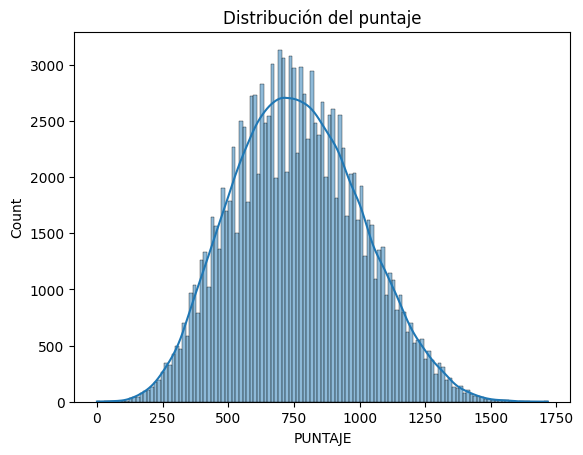

In [ ]:
#solo para variable PUNTAJE que es numérica
sns.histplot(df['PUNTAJE'], kde=True)
plt.title('Distribución del puntaje')
plt.show()

# 3.2. Variables Affecting the Target

In [ ]:
#AÑO_PERIODO were excluded as they are not relevant to the analysis.
#df.drop(['AÑO_PERIODO'],axis = 1, inplace = True)
df.head()

,CARRERA,PUNTAJE,ESTATUS,SEDE,PERIODO,AÑO_PERIODO,Nº POSTULACION,SEXO,EDAD,TIPO_COLEGIO
13550,ENFERMERÍA,644.875,NO INGRESO,LIMA,II,2023-II,1,M,21,Privado
40901,ENFERMERÍA,639.250,NO INGRESO,LIMA,I,2024-I,2,M,21,Privado
68096,ENFERMERÍA,686.000,NO INGRESO,LIMA,II,2024-II,3,M,21,Privado
92839,ENFERMERÍA,947.000,NO INGRESO,LIMA,I,2025-I,4,M,21,Privado
132861,ADMINISTRACIÓN DE NEGOCIOS INTERNACIONALES,1216.000,INGRESO,S.J.L,II,2025-II,5,M,21,Privado


In [ ]:
#ESTATUS was converted to a binary variable.
df['TARGET'] = df['ESTATUS'].map({'NO INGRESO': 0, 'INGRESO': 1})
df.drop(columns=['ESTATUS'], inplace=True)

In [ ]:
df.head()

,CARRERA,PUNTAJE,SEDE,PERIODO,AÑO_PERIODO,Nº POSTULACION,SEXO,EDAD,TIPO_COLEGIO,TARGET
13550,ENFERMERÍA,644.875,LIMA,II,2023-II,1,M,21,Privado,0
40901,ENFERMERÍA,639.250,LIMA,I,2024-I,2,M,21,Privado,0
68096,ENFERMERÍA,686.000,LIMA,II,2024-II,3,M,21,Privado,0
92839,ENFERMERÍA,947.000,LIMA,I,2025-I,4,M,21,Privado,0
132861,ADMINISTRACIÓN DE NEGOCIOS INTERNACIONALES,1216.000,S.J.L,II,2025-II,5,M,21,Privado,1


In [ ]:
#Categorical and numerical variables were identified.
target = 'TARGET'
cat_var = ['CARRERA', 'SEXO', 'TIPO_COLEGIO', 'PERIODO', 'SEDE']
num_var = ['PUNTAJE', 'EDAD', 'Nº POSTULACION']

Categorical Variables

In [ ]:
def chi2_test(df, cat_vars, target):
    results = []
    for var in cat_vars:
        tabla = pd.crosstab(df[var], df[target])
        chi2, p, dof, ex = chi2_contingency(tabla)
        results.append({'Variable': var, 'p-value': p})
    return pd.DataFrame(results).sort_values('p-value')

chi2_results = chi2_test(df, cat_var, 'TARGET')
display(chi2_results)

,Variable,p-value
0,CARRERA,0.000000e+00
4,SEDE,0.000000e+00
3,PERIODO,1.622869e-226
1,SEXO,9.538097e-61
2,TIPO_COLEGIO,8.413837e-02


<ipython-input-131-fecb6e357071>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




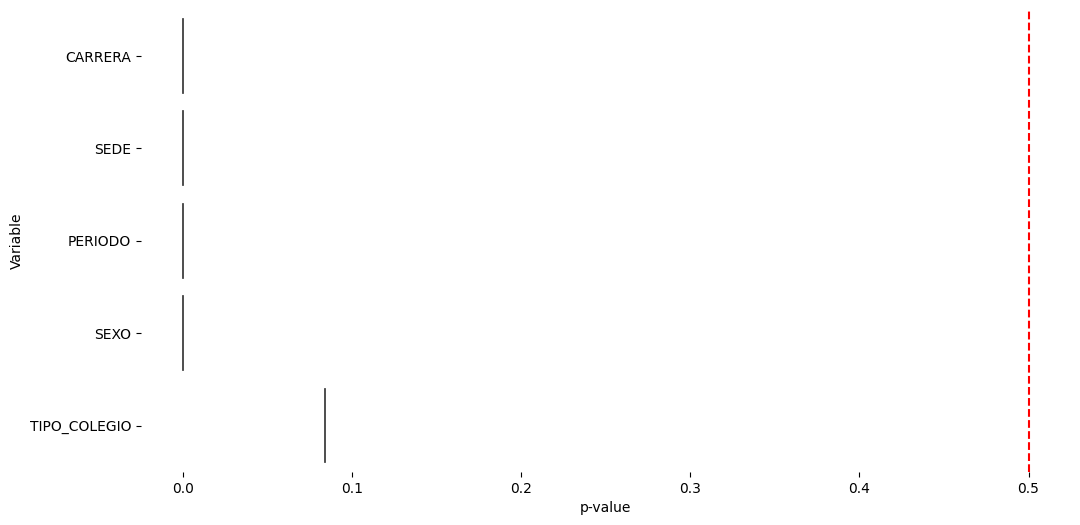

In [ ]:
figsize = (12, 1.2 * len(chi2_results['Variable'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(chi2_results, x='p-value', y='Variable', inner='stick', palette='Dark2')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=1.5, label='x = 0.5')
sns.despine(top=True, right=True, bottom=True, left=True)

Insight: Most categorical variables are relevant to the admission outcome.

Numerical Variables

In [ ]:
def ttest_variables(df, num_vars, target):
    results = []
    grupo_1 = df[df[target] == 1]
    grupo_0 = df[df[target] == 0]
    for var in num_vars:
        t_stat, p_val = ttest_ind(grupo_1[var], grupo_0[var], nan_policy='omit')
        results.append({'Variable': var, 'p-value': p_val})
    return pd.DataFrame(results)

ttest_results = ttest_variables(df, num_var, 'TARGET')
display(ttest_results)

,Variable,p-value
0,PUNTAJE,0.000000
1,EDAD,0.418061
2,Nº POSTULACION,0.000000


<ipython-input-133-acf39d41fc0f>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




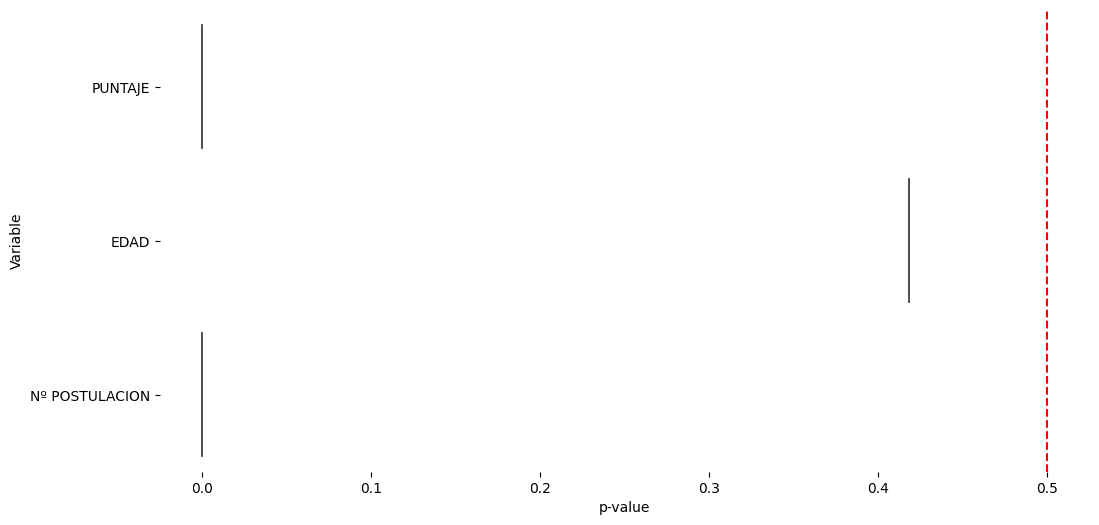

In [ ]:
figsize = (12, 1.2 * len(chi2_results['Variable'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(ttest_results,x='p-value',y='Variable',inner='stick',palette='Dark2')
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=1.5, label='x = 0.5')
sns.despine(top=True, right=True, bottom=True, left=True)

Insight: PUNTAJE and Nº POSTULACION are important numerical predictors of admission. EDAD does not show a statistically significant effect.

In [ ]:
#Dropping 'EDAD' and 'TIPO_COLEGIO' since they are no longer needed
#df.drop(columns=['EDAD','TIPO_COLEGIO'], inplace=True)

In [ ]:
#cat_var = ['CARRERA', 'SEXO', 'PERIODO', 'SEDE','TIPO_COLEGIO']
#num_var = ['PUNTAJE', 'Nº POSTULACION']

# **4. MODELLING**

# 4.1. Variable Transformation

### Data Split

First, we split the dataset as follows:

| Set           | Percentage | Purpose                              |
|---------------|------------|------------------------------------|
| **Training**  | 80% diferent to 2025-II       | Train the model                    |
| **Validation**| 20% diferent to 2025-II      | Tune hyperparameters               |
| **Test**      | All 2025-II data        | Evaluate the final model performance|

In [ ]:
y = df[target]
año_periodo = df['AÑO_PERIODO']

#variables predictoras seleccionadas
num_var = ['PUNTAJE', 'Nº POSTULACION']
cat_var = ['CARRERA', 'SEXO', 'PERIODO', 'TIPO_COLEGIO', 'SEDE']

selected_features = num_var + cat_var
X = df[selected_features]

#separación de data según el valor de AÑO_PERIODO
X_train_ = X[año_periodo != '2025-II']
X_test = X[año_periodo == '2025-II']
y_train_ = y[año_periodo != '2025-II']
y_test = y[año_periodo == '2025-II']

#divisiçon de data de X_train y y_train en entrenamiento y validación  80% train / 20% val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_, y_train_, test_size=0.2, random_state=42, stratify=y_train_
)

#confirmamos proporciones
print(f'Train: {len(X_train)} registros')
print(f'Validación: {len(X_val)} registros')
print(f'Test: {len(X_test)} registros')

Train: 82292 registros
Validación: 20574 registros
Test: 27377 registros


In [ ]:
'''X = df.drop(columns=[target])
y = df[target]

#Separation of 15% of data for testing
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

#Splitting the remaining 85% into training (70%) and validation (15%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)

print(f'Train: {len(X_train)} registros')
print(f'Validación: {len(X_val)} registros')
print(f'Test: {len(X_test)} registros')'''

"X = df.drop(columns=[target])\ny = df[target]\n\n#Separation of 15% of data for testing\nX_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)\n\n#Splitting the remaining 85% into training (70%) and validation (15%)\nX_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)\n\nprint(f'Train: {len(X_train)} registros')\nprint(f'Validación: {len(X_val)} registros')\nprint(f'Test: {len(X_test)} registros')"

Variable transformations are done after splitting the dataset to prevent data leakage—where information from test or validation sets leaks into training.

For instance, applying StandardScaler before splitting uses test data to calculate the mean and std, biasing evaluation.

Similarly, using OneHotEncoder before the split can expose rare categories from the test set, giving the model premature clues.

In [ ]:
#categorical variables are transformed using OneHotEncoder, and numerical variables are scaled with StandardScaler.
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_var),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_var)
])

StandardScaler normalizes numeric features.

OneHotEncoder converts categorical features into dummy variables (0s and 1s).

# **4.2. Data Training**

In [ ]:
#function to evaluate multiple classification models, each with specified hyperparameters.

def evaluate_classifiers(X_train, y_train, X_val, y_val, X_test, y_test, preprocessor): #Iterates through a dictionary of models, each with its own hyperparameters.

    #Handles class imbalance: checks class distribution and applies oversampling if the minority class is less than 10% of the majority.
    distribucion_clases = y_train.value_counts()
    print("Distribución de Clases en el Conjunto de Entrenamiento:")
    print(distribucion_clases)

    proporción = distribucion_clases.min() / distribucion_clases.max()
    print(f"Proporción de clases: {proporción:.4f}")

    #oversampling
    if proporción < 0.2:
        oversampler = RandomOverSampler(random_state=42)
        X_train, y_train = oversampler.fit_resample(X_train, y_train)
        print("Oversampling aplicado. Nueva distribución de clases:")
        print(y_train.value_counts())
    else:
        print("No se aplicó oversampling, la distribución de clases es aceptable.")

    #Builds a pipeline for each model, including preprocessing and classifier.
    models = {
        'Random Forest': (RandomForestClassifier(), {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None]
        }),
        'Logistic Regression': (LogisticRegression(max_iter=1000), {
            'classifier__C': [0.1, 1, 10]
        }),
        'XGBoost': (XGBClassifier(eval_metric='logloss'), {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 5]
        }),
        'KNN': (KNeighborsClassifier(), {
            'classifier__n_neighbors': [3, 5, 7]
        }),
        #'SVM': (SVC(), {
            #'classifier__C': [0.1, 1, 10],
            #'classifier__kernel': ['linear', 'rbf']
        #})
    }

    results = []
    best_models = {}

    #Pipeline -
    for name, (clf, params) in models.items():
        print(f"\n Entrenando y ajustando hiperparámetros para: {name}")
        pipeline = Pipeline(steps=[
            ('preprocessing', preprocessor),  #transformación de variables con ColumnTransformer
            ('classifier', clf)
        ])

        grid = GridSearchCV(pipeline, param_grid=params, cv=3, scoring='accuracy', n_jobs=-1)  #Uses GridSearchCV to tune hyperparameters via cross-validation.
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_  #Trains the model and evaluates accuracy on the test set.
        y_pred_test = best_model.predict(X_test)

        acc = accuracy_score(y_test, y_pred_test)  #una vez encontrado el mejor modelo, se predice el conjunto de prueba y se calcula la precisión (accuracy).
        print(f"✅ {name} - Accuracy en test: {acc:.4f}")

        results.append({    #Stores results in a list and converts them to a DataFrame for display.
            'Model': name,
            'Accuracy': acc,
            'Best Params': grid.best_params_
        })

        best_models[name] = best_model #Saves the best-performing model by name.

    #Displays results as a table and plots model accuracies.
    df_results = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
    print("\n📊 Resultados Comparativos:")
    print(df_results)

    best_model_name = df_results.iloc[0]['Model']
    best_model_overall = best_models[best_model_name]

    plt.figure(figsize=(10, 5))
    sns.barplot(x='Accuracy', y='Model', data=df_results, palette='viridis')
    plt.title('Comparación de Accuracy por Modelo')
    plt.xlabel('Accuracy en Test')
    plt.ylabel('Modelo')
    plt.xlim(0, 1)
    plt.show()

    return best_models, df_results, best_model_name, best_model_overall

Distribución de Clases en el Conjunto de Entrenamiento:
TARGET
0    73446
1     8846
Name: count, dtype: int64
Proporción de clases: 0.1204
Oversampling aplicado. Nueva distribución de clases:
TARGET
0    73446
1    73446
Name: count, dtype: int64

 Entrenando y ajustando hiperparámetros para: Random Forest
✅ Random Forest - Accuracy en test: 0.7743

 Entrenando y ajustando hiperparámetros para: Logistic Regression
✅ Logistic Regression - Accuracy en test: 0.6750

 Entrenando y ajustando hiperparámetros para: XGBoost
✅ XGBoost - Accuracy en test: 0.7418

 Entrenando y ajustando hiperparámetros para: KNN
✅ KNN - Accuracy en test: 0.7468

📊 Resultados Comparativos:
                 Model  Accuracy  \
0        Random Forest  0.774336   
3                  KNN  0.746795   
2              XGBoost  0.741791   
1  Logistic Regression  0.674983   

                                         Best Params  
0  {'classifier__max_depth': None, 'classifier__n...  
3                     {'classifier__n

<ipython-input-139-bc545db15320>:81: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




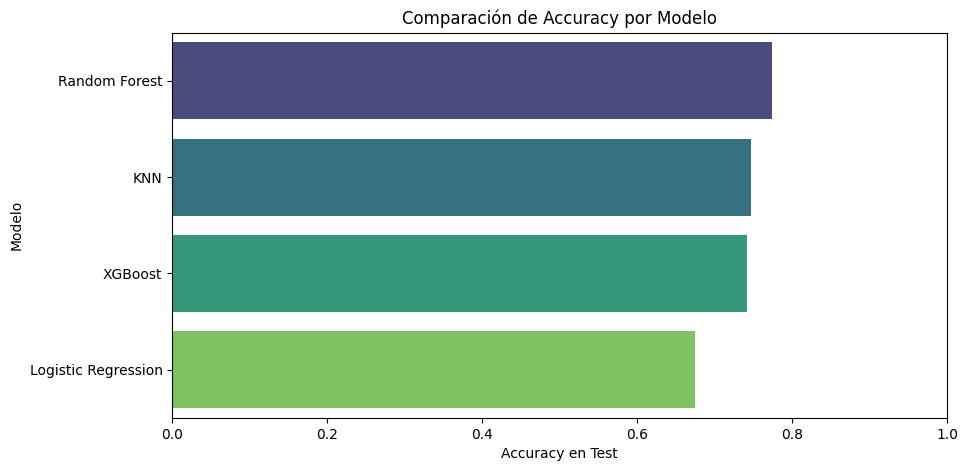

In [ ]:
best_models, df_results, best_model_name, best_model_overall = evaluate_classifiers(X_train, y_train, X_val, y_val, X_test, y_test, preprocessor)

In [ ]:
print(f"Mejor modelo: {best_model_name}")

Mejor modelo: Random Forest


In [ ]:
#Saving the best model to a .pkl file.
joblib.dump(best_model_overall, 'modelo_entrenado.pkl')

['modelo_entrenado.pkl']

In [ ]:
files.download('modelo_entrenado.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(preprocessor, 'preprocesador.pkl')
files.download('preprocesador.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Loading the saved model.
modelo = joblib.load('modelo_entrenado.pkl')

#4.3. Model Validation

🔍 Accuracy en Validación: 0.9651

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18362
           1       0.83      0.85      0.84      2212

    accuracy                           0.97     20574
   macro avg       0.91      0.91      0.91     20574
weighted avg       0.97      0.97      0.97     20574



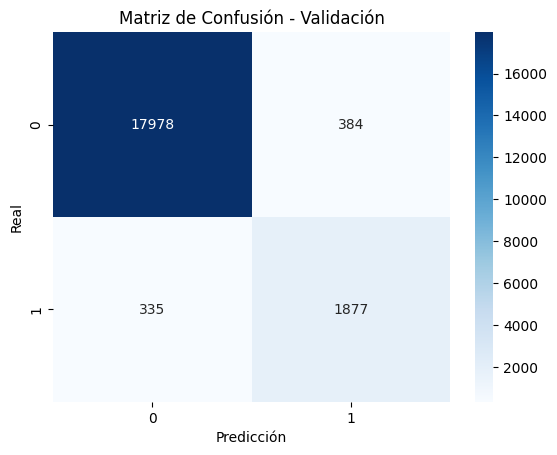

In [ ]:
#Making predictions on the validation set.
y_pred_val = modelo.predict(X_val)

#Calculating accuracy.
acc_val = accuracy_score(y_val, y_pred_val)
print(f"🔍 Accuracy en Validación: {acc_val:.4f}")

#Generates a full classification report.
print("\n📋 Classification Report:")
print(classification_report(y_val, y_pred_val))

#confusion matrix.
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Validación')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [ ]:
#Simulating new applicants
new_data = pd.DataFrame([
    {
        'CARRERA': 'INGENIERÍA INDUSTRIAL',
        'PUNTAJE': 1200,
        'SEDE': 'LIMA',
        'PERIODO': 'I',
        'Nº POSTULACION': 1,
        'SEXO': 'F',
        'TIPO_COLEGIO': 'PRIVADO'
    },
    {
        'CARRERA': 'MEDICINA HUMANA',
        'PUNTAJE': 950,
        'SEDE': 'HUANCAYO',
        'PERIODO': 'II',
        'Nº POSTULACION': 2,
        'SEXO': 'M',
        'TIPO_COLEGIO': 'NACIONAL'
    },
    {
        'CARRERA': 'ADMINISTRACIÓN DE EMPRESAS',
        'PUNTAJE': 750,
        'SEDE': 'LIMA',
        'PERIODO': 'II',
        'Nº POSTULACION': 1,
        'SEXO': 'F',
        'TIPO_COLEGIO': 'PRIVADO'
    }
])

#Predicting admission
predicciones = modelo.predict(new_data)
print(predicciones)

[0 0 0]


In [ ]:
# Obtener lista única de carreras
carreras = df['CARRERA'].dropna().unique()
carreras = sorted([c.strip().upper() for c in carreras])

# Guardar en archivo .txt
with open('carreras.txt', 'w', encoding='utf-8') as f:
    for carrera in carreras:
        f.write(carrera + '\n')
# Descargar el archivo en Colab
files.download('carreras.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(modelo, 'modelo_entrenado.pkl', compress=3)
files.download('modelo_entrenado.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df['SEDE'].unique()

array(['LIMA', 'S.J.L', 'VILLA RICA', 'HUARAL', 'CHILCA', 'HUARMEY',
       'OYÓN', 'CHANCAY'], dtype=object)